In [3]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
from scipy.stats import linregress
from pprint import pprint
from Config import api_key
from Config import email

In [87]:
sn=input ("Enter in the State")

Enter in the State florida


In [88]:
sn=sn.title()

In [89]:
#Access the epa site for state information
state_url="https://aqs.epa.gov/data/api/list/states"
para = {
    "email":email,
    "key":api_key,
}
state_response = requests.get(state_url, params=para).json()
state_data = state_response["Data"]

# pprint(state_response)

state_code=[]
state_name=[]

for stat in state_data:
    state_code.append(stat["code"])
    state_name.append(stat["value_represented"])

In [90]:
#Look for the state code for the input state and capture it in dataframe

state_code_df=pd.DataFrame({"State Code":state_code,
                           "State Name": state_name})

In [91]:
state_code_df.set_index("State Name",inplace=True)

state_parameter=state_code_df.loc[sn,"State Code"]

state_parameter

'12'

In [92]:
#Grab Counties by given state from the EPA API

#API 
base_url="https://aqs.epa.gov/data/api/list/countiesByState"
param = {
    "email":email,
    "key":api_key,
    "state":state_parameter
}

response = requests.get(base_url, params=param).json()
data = response["Data"]

#Creating list for county information
county_code=[]
county=[]

for list in data:
    county.append(list["value_represented"])
    county_code.append(list["code"])


In [93]:
#look for the county code for the input state

county_code_df=pd.DataFrame({"County Code":county_code,
                           "County Name": county})

county_code_df

,County Code,County Name
0,001,Alachua
1,003,Baker
2,005,Bay
3,007,Bradford
4,009,Brevard
...,...,...
63,125,Union
64,127,Volusia
65,129,Wakulla
66,131,Walton


In [94]:
cnty=input ("Enter the county")

Enter the county miami-dade


In [95]:
cnty=cnty.title()

In [96]:
#Find the county code for the input county
county_code_df.set_index("County Name",inplace=True)

county_parameter=county_code_df.loc[cnty,"County Code"]

county_parameter

'086'

In [97]:
#Grabing the Site by county
data_county_code=[]
data_site_code=[]
data_site_name=[]

#API
base_url2="https://aqs.epa.gov/data/api/list/sitesByCounty"
param = {
    "email":email,
    "key":api_key,
    "state":state_parameter,
    "county":county_parameter
}

#If looking to pull data for all counties use code block below
site_response = requests.get(base_url2, params=param).json()
site_data=site_response["Data"]

#Only capture the none zero data
for list in site_data:
    if list["value_represented"] is not None:
            
        data_county_code.append(county_parameter)
        data_site_name.append(list["value_represented"])
        data_site_code.append(list["code"])
            
            

In [98]:
#To be used if wanting to look for all counties
# #Loop through the counties grabbed for the state
# for county_c in county_code:
#     param["county"]=county_c

#     site_response = requests.get(base_url2, params=param).json()
#     site_data=site_response["Data"]
    
#     #Only capture the none zero data
#     for list in site_data:
#         if list["value_represented"] is not None:
            
#             data_county_code.append(county_c)
#             data_site_name.append(list["value_represented"])
#             data_site_code.append(list["code"])
            

In [99]:
#Create a dataframe for collected data 
df=pd.DataFrame({
    "County Code":data_county_code,
    "Site Name":data_site_name,
    "Site Code":data_site_code
})

df

,County Code,Site Name,Site Code
0,086,PENNSUCO,0019
1,086,Rosenstiel,0027
2,086,Perdue,0029
3,086,SITE MOVED ACROSS ROAD FROM BEARD CENTER TO BE...,0030
4,086,Coral Reef,0031
5,086,Palm Springs Fire Station,0033
6,086,KENDALL,0034
7,086,Perimeter Road,0035
8,086,Miami Fire Station,1016
9,086,Lab Annex,4002


In [100]:
#Adding Columns for data to collect
df["State"]=""
df["County"]=""
df["City"]=""
df["Latitude"]=""
df["Longitude"]=""
df["Average PM 2.5"]=""
df["Median PM 2.5"]=""
df["Standard Deviation"]=""
df["Date of Last Change"]=""
df.head()

,County Code,Site Name,Site Code,State,County,City,Latitude,Longitude,Average PM 2.5,Median PM 2.5,Standard Deviation,Date of Last Change
0,086,PENNSUCO,0019,,,,,,,,,
1,086,Rosenstiel,0027,,,,,,,,,
2,086,Perdue,0029,,,,,,,,,
3,086,SITE MOVED ACROSS ROAD FROM BEARD CENTER TO BE...,0030,,,,,,,,,
4,086,Coral Reef,0031,,,,,,,,,


In [101]:
#capturing Data from the epa API

#API
anual_url="https://aqs.epa.gov/data/api/annualData/bySite"

parameters={
    "email":email,
    "key":api_key,
    "bdate":"20180101",
    "edate":"20181231",
    "state":state_parameter,
    "param":"88101",
# To be removed pending on if mult counties are to be used
    "county":county_parameter

}

#Loop through to collect data 

for index, row in df.iterrows():
    
#     ct=row["County Code"]
#     parameters["county"] = ct

    st=row["Site Code"]
    parameters["site"] = st
    print_name=row["Site Name"]
        
    anual_response=requests.get(anual_url,params=parameters).json()
       
    try:
        out=anual_response["Data"][0]
  
        State=out["state"]
        city = out["city"]
        lat=out["latitude"]
        long=out["longitude"]
        PM=out["arithmetic_mean"]
        dloc=out["date_of_last_change"]
        std=out["standard_deviation"]
        med=out["fiftieth_percentile"]
        cou=out["county"]
        
        df.loc[index, "State"]=State
        df.loc[index, "County"]=cou
#        df.loc[index, "County Code"]=county_c
        df.loc[index, "City"]=city
        df.loc[index, "Latitude"]=lat
        df.loc[index, "Longitude"]=long
        df.loc[index, "Average PM 2.5"]=PM
        df.loc[index, "Median PM 2.5"]=med
        df.loc[index, "Standard Deviation"]=std
        df.loc[index, "Date of Last Change"]=dloc
        print(f"Adding location {print_name} from {city} in data")
        
    except (KeyError, IndexError):
        print(f"Missing field/result for {print_name}... skipping.")


Missing field/result for PENNSUCO... skipping.
Missing field/result for Rosenstiel... skipping.
Missing field/result for Perdue... skipping.
Missing field/result for SITE MOVED ACROSS ROAD FROM BEARD CENTER TO BEHIND IORI RESEARCH BLD... skipping.
Missing field/result for Coral Reef... skipping.
Adding location Palm Springs Fire Station from Palm Springs North in data
Missing field/result for KENDALL... skipping.
Missing field/result for Perimeter Road... skipping.
Adding location Miami Fire Station from Miami in data
Missing field/result for Lab Annex... skipping.
Adding location HOMESTEAD FIRE STATION from Homestead in data


In [102]:
df.head()

,County Code,Site Name,Site Code,State,County,City,Latitude,Longitude,Average PM 2.5,Median PM 2.5,Standard Deviation,Date of Last Change
0,086,PENNSUCO,0019,,,,,,,,,
1,086,Rosenstiel,0027,,,,,,,,,
2,086,Perdue,0029,,,,,,,,,
3,086,SITE MOVED ACROSS ROAD FROM BEARD CENTER TO BE...,0030,,,,,,,,,
4,086,Coral Reef,0031,,,,,,,,,


In [103]:
#Clean the data by dropping rows that has blank for county
drop_index=df.loc[df["County"]==""].index

clean_df=df.drop(drop_index)

In [104]:
clean_df

,County Code,Site Name,Site Code,State,County,City,Latitude,Longitude,Average PM 2.5,Median PM 2.5,Standard Deviation,Date of Last Change
5,086,Palm Springs Fire Station,0033,Florida,Miami-Dade,Palm Springs North,25.9419,-80.3264,6.66777,6,2.74178,2019-03-15
8,086,Miami Fire Station,1016,Florida,Miami-Dade,Miami,25.7942,-80.2156,7.48833,7.3,2.05996,2018-08-31
10,086,HOMESTEAD FIRE STATION,6001,Florida,Miami-Dade,Homestead,25.4719,-80.4828,6.77647,6,2.87749,2019-02-19


In [105]:
#save to csv file
clean_df.to_csv("2018 csv/Miami-Dade County Air Polution Data.csv")

In [108]:
#Drop the columns that will not be needed
final_df=clean_df.drop(columns=['County Code', 'Site Name', 'Site Code', 'State', 'County', 'Latitude', 'Longitude', 'Median PM 2.5', 'Standard Deviation', 'Date of Last Change'])
final_df

,City,Average PM 2.5
5,Palm Springs North,6.66777
8,Miami,7.48833
10,Homestead,6.77647


In [1]:
#save to csv file
final_df.to_csv("2018 csv/Miami-Dade County PM2.5.csv")

NameError: name 'final_df' is not defined

In [4]:
# Study data files created from above
cook_file_loc = "2018 csv/Cook County Air Polution Data.csv"
la_file_loc = "2018 csv/Los Angeles County Air Polution Data.csv"
sf_file_loc = "2018 csv/San Francisco County Air Polution Data.csv"
ny_file_loc = "2018 csv/New York County Air Polution Data.csv"
harris_file_loc = "2018 csv/Harris County Air Polution Data.csv"
baldwin_file_loc = "2018 csv/Baldwin County Air Polution Data.csv"
chatham_file_loc = "2018 csv/Chatham County Air Polution Data.csv"
denver_file_loc = "2018 csv/Denver County Air Polution Data.csv"
duval_file_loc = "2018 csv/Duval County Air Polution Data.csv"
miami_file_loc = "2018 csv/Miami-Dade County Air Polution Data.csv"
multnomah_file_loc = "2018 csv/Multnomah County Air Polution Data.csv"
orleans_file_loc = "2018 csv/Orleans County Air Polution Data.csv"
suffolk_file_loc = "2018 csv/Suffolk County Air Polution Data.csv"
wyandotte_file_loc = "2018 csv/Wyandotte County Air Polution Data.csv"


# Read the weather data and the study results
cook_data = pd.read_csv(cook_file_loc)
la_data = pd.read_csv(la_file_loc)
sf_data = pd.read_csv(sf_file_loc)
ny_data = pd.read_csv(ny_file_loc)
harris_data = pd.read_csv(harris_file_loc)
baldwin_data = pd.read_csv(baldwin_file_loc)
chatham_data = pd.read_csv(chatham_file_loc) 
denver_data = pd.read_csv(denver_file_loc)
duval_data = pd.read_csv(duval_file_loc)
miami_data = pd.read_csv(miami_file_loc)
multnomah_data = pd.read_csv(multnomah_file_loc) 
orleans_data = pd.read_csv(orleans_file_loc) 
suffolk_data = pd.read_csv(suffolk_file_loc)
wyandotte_data = pd.read_csv(wyandotte_file_loc)



In [5]:
# Pull population csv file obtained from Census website
pop_file_loc = "2018 csv/city population.csv"

# Read the weather data and the study results
pop_data = pd.read_csv(pop_file_loc)

pop_data.head()

,Geography,Population (2010),Population (2011),Population (2012),Population (2013),Population (2014),Population (2015),Population (2016),Population (2017),Population (2018)
0,"Abbeville city, Alabama",2684,2677,2629,2612,2595,2588,2573,39091,2563
1,"Adamsville city, Alabama",4510,4496,4474,4453,4432,4406,4373,40867,4325
2,"Addison town, Alabama",751,751,744,743,740,735,734,37253,724
3,"Akron town, Alabama",355,345,345,341,339,337,332,36857,330
4,"Alabaster city, Alabama",31186,31346,31653,31946,32149,32739,32984,33223,33340


In [6]:
#Creating separate city and state columns
pop_data["City"]=""
pop_data["State"]=""

for index, row in pop_data.iterrows():

    split_name=row["Geography"].split(",")
    pop_data.loc[index, "City"]=split_name[0]
    pop_data.loc[index, "State"]=split_name[1]
    
#Removing space for state list to be able to match properly
rename=pop_data["State"]
state_name= [name.strip() for name in rename]
    
pop_data["State"]=state_name

pop_data.head()

,Geography,Population (2010),Population (2011),Population (2012),Population (2013),Population (2014),Population (2015),Population (2016),Population (2017),Population (2018),City,State
0,"Abbeville city, Alabama",2684,2677,2629,2612,2595,2588,2573,39091,2563,Abbeville city,Alabama
1,"Adamsville city, Alabama",4510,4496,4474,4453,4432,4406,4373,40867,4325,Adamsville city,Alabama
2,"Addison town, Alabama",751,751,744,743,740,735,734,37253,724,Addison town,Alabama
3,"Akron town, Alabama",355,345,345,341,339,337,332,36857,330,Akron town,Alabama
4,"Alabaster city, Alabama",31186,31346,31653,31946,32149,32739,32984,33223,33340,Alabaster city,Alabama


In [8]:
#Drop columns that are not needed
clean_pop=pop_data.drop(columns=['Geography','Population (2010)', 'Population (2011)',
       'Population (2012)', 'Population (2013)', 'Population (2014)',
       'Population (2015)', 'Population (2016)', 'Population (2017)'])

clean_pop.head(75)

,Population (2018),City,State
0,2563,Abbeville city,Alabama
1,4325,Adamsville city,Alabama
2,724,Addison town,Alabama
3,330,Akron town,Alabama
4,33340,Alabaster city,Alabama
...,...,...,...
70,1196,Chatom town,Alabama
71,13531,Chelsea city,Alabama
72,1004,Cherokee town,Alabama
73,5745,Chickasaw city,Alabama


In [9]:
#clean the dataframes for fuzzy matching

cook_state=cook_data["State"][0]
la_state=la_data["State"][0]
sf_state=sf_data["State"][0]
ny_state=ny_data["State"][0]
harris_state=harris_data["State"][0]
baldwin_state = baldwin_data["State"][0]
chatham_state = chatham_data["State"][0]
denver_state = denver_data["State"][0]
duval_state = duval_data["State"][0]
miami_state = miami_data["State"][0]
multnomah_state = multnomah_data["State"][0] 
orleans_state = orleans_data["State"][0]
suffolk_state =suffolk_data["State"][0]
wyandotte_state = wyandotte_data["State"][0]


cook_pop=clean_pop.loc[clean_pop["State"]==cook_state]
la_pop=clean_pop.loc[clean_pop["State"]==la_state]
sf_pop=clean_pop.loc[clean_pop["State"]==sf_state]
ny_pop=clean_pop.loc[clean_pop["State"]==ny_state]
harris_pop=clean_pop.loc[clean_pop["State"]==harris_state]
baldwin_pop =clean_pop.loc[clean_pop["State"]==baldwin_state] 
chatham_pop =clean_pop.loc[clean_pop["State"]==chatham_state]
denver_pop =clean_pop.loc[clean_pop["State"]==denver_state]
duval_pop =clean_pop.loc[clean_pop["State"]==duval_state]
miami_pop =clean_pop.loc[clean_pop["State"]==miami_state]
multnomah_pop =clean_pop.loc[clean_pop["State"]==multnomah_state] 
orleans_pop =clean_pop.loc[clean_pop["State"]==orleans_state]
suffolk_pop =clean_pop.loc[clean_pop["State"]==suffolk_state]
wyandotte_pop =clean_pop.loc[clean_pop["State"]==wyandotte_state]



In [10]:
#Fuzzy match the data frames from two different sources on city name

from fuzzywuzzy import process, fuzz

cook_matched_city= cook_data["City"].map(lambda x: process.extractOne(x, cook_pop['City'], scorer=fuzz.partial_ratio)[0])
la_matched_city= la_data["City"].map(lambda x: process.extractOne(x, la_pop['City'], scorer=fuzz.partial_ratio)[0])
sf_matched_city= sf_data["City"].map(lambda x: process.extractOne(x, sf_pop['City'], scorer=fuzz.partial_ratio)[0])
ny_matched_city= ny_data["City"].map(lambda x: process.extractOne(x, ny_pop['City'], scorer=fuzz.partial_ratio)[0])
harris_matched_city= harris_data["City"].map(lambda x: process.extractOne(x, harris_pop['City'], scorer=fuzz.partial_ratio)[0])
baldwin_matched_city=baldwin_data["City"].map(lambda x: process.extractOne(x, baldwin_pop['City'], scorer=fuzz.partial_ratio)[0])
chatham_matched_city=chatham_data["City"].map(lambda x: process.extractOne(x, chatham_pop['City'], scorer=fuzz.partial_ratio)[0])
denver_matched_city=denver_data["City"].map(lambda x: process.extractOne(x, denver_pop['City'], scorer=fuzz.partial_ratio)[0])
duval_matched_city=duval_data["City"].map(lambda x: process.extractOne(x, duval_pop['City'], scorer=fuzz.partial_ratio)[0])
miami_matched_city=miami_data["City"].map(lambda x: process.extractOne(x, miami_pop['City'], scorer=fuzz.partial_ratio)[0])
multnomah_matched_city=multnomah_data["City"].map(lambda x: process.extractOne(x, multnomah_pop['City'], scorer=fuzz.partial_ratio)[0])
orleans_matched_city=orleans_data["City"].map(lambda x: process.extractOne(x, orleans_pop['City'], scorer=fuzz.partial_ratio)[0])
suffolk_matched_city=suffolk_data["City"].map(lambda x: process.extractOne(x, suffolk_pop['City'], scorer=fuzz.partial_ratio)[0])
wyandotte_matched_city=wyandotte_data["City"].map(lambda x: process.extractOne(x, wyandotte_pop['City'], scorer=fuzz.partial_ratio)[0])



#Replacing the city name with matched name
cook_data["City"]=cook_matched_city
la_data["City"]=la_matched_city
sf_data["City"]=sf_matched_city
ny_data["City"]=ny_matched_city
harris_data["City"]=harris_matched_city
baldwin_data["City"]=baldwin_matched_city
chatham_data["City"]=chatham_matched_city
denver_data["City"]=denver_matched_city
duval_data["City"]=duval_matched_city
miami_data["City"]=miami_matched_city
multnomah_data["City"]=multnomah_matched_city
orleans_data["City"]=orleans_matched_city
suffolk_data["City"]=suffolk_matched_city
wyandotte_data["City"]=wyandotte_matched_city

In [11]:
#Creating dataframe for plot
scatter1=pd.merge(left=cook_data,
                right=cook_pop,
                how="left",
                on="City")

pivot1=scatter1.groupby("City")
clean_scatter1=pivot1.mean()

scatter2=pd.merge(left=la_data,
                right=la_pop,
                how="left",
                on="City")

pivot2=scatter2.groupby("City")
clean_scatter2=pivot2.mean()

scatter3=pd.merge(left=sf_data,
                right=sf_pop,
                how="left",
                on="City")

pivot3=scatter3.groupby("City")
clean_scatter3=pivot3.mean()

scatter4=pd.merge(left=ny_data,
                right=ny_pop,
                how="left",
                on="City")

pivot4=scatter4.groupby("City")
clean_scatter4=pivot4.mean()

scatter5=pd.merge(left=harris_data,
                right=harris_pop,
                how="left",
                on="City")

pivot5=scatter5.groupby("City")
clean_scatter5=pivot5.mean()

scatter6=pd.merge(left=baldwin_data,
                right=baldwin_pop,
                how="left",
                on="City")

pivot6=scatter6.groupby("City")
clean_scatter6=pivot6.mean()

scatter7=pd.merge(left=chatham_data,
                right=chatham_pop,
                how="left",
                on="City")

pivot7=scatter7.groupby("City")
clean_scatter7=pivot7.mean()

scatter8=pd.merge(left=denver_data,
                right=denver_pop,
                how="left",
                on="City")

pivot8=scatter8.groupby("City")
clean_scatter8=pivot8.mean()

scatter9=pd.merge(left=duval_data,
                right=duval_pop,
                how="left",
                on="City")

pivot9=scatter9.groupby("City")
clean_scatter9=pivot9.mean()

scatter10=pd.merge(left=miami_data,
                right=miami_pop,
                how="left",
                on="City")

pivot10=scatter10.groupby("City")
clean_scatter10=pivot10.mean()


scatter11=pd.merge(left=multnomah_data,
                right=multnomah_pop,
                how="left",
                on="City")

pivot11=scatter11.groupby("City")
clean_scatter11=pivot11.mean()

scatter12=pd.merge(left=orleans_data,
                right=orleans_pop,
                how="left",
                on="City")

pivot12=scatter12.groupby("City")
clean_scatter12=pivot12.mean()

scatter13=pd.merge(left=suffolk_data,
                right=suffolk_pop,
                how="left",
                on="City")

pivot13=scatter13.groupby("City")
clean_scatter13=pivot13.mean()

scatter14=pd.merge(left=wyandotte_data,
                right=wyandotte_pop,
                how="left",
                on="City")

pivot14=scatter14.groupby("City")
clean_scatter14=pivot14.mean()

city_merge=scatter1.append([scatter2,scatter3,scatter4,scatter5,scatter6,scatter7,scatter8,scatter9,scatter10, scatter11,scatter12,scatter13,scatter14],ignore_index=True)
total_df=city_merge.groupby(by="City").mean()

In [12]:
bar_tot=total_df["Population (2018)"]


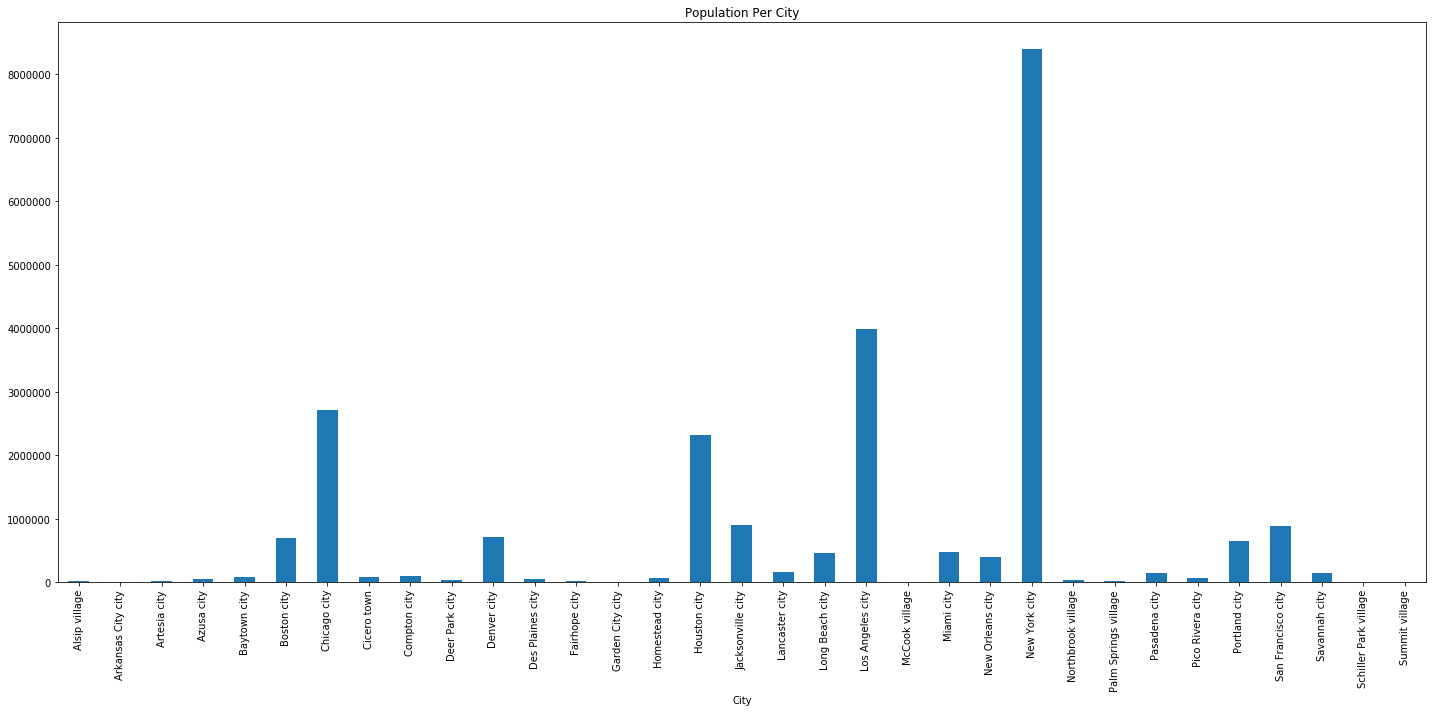

In [13]:
#Plot total popuation
ar_tot.plot(kind="bar", figsize=(20,10))
plt.title("Population Per City")
plt.tight_layout()

plt.savefig("plot/population.png")

plt.show()


In [14]:
#Function to plot linear regression line 

def linear_regression(x_values, y_values, eq_loc):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,2)) + "\n" + "R Value: " + str(rvalue)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,eq_loc,fontsize=15,color="red")

    print(f"The correlation between is: {rvalue}")


In [15]:
#function to plot scatter plot

def scat_plot(x_values, y_values, y_label,c):
    plt.scatter(x_values, y_values,"o",c)
    plt.title(f"Population vs. {y_label}")
    plt.xlabel("Population")
    plt.ylabel(y_label)

The correlation between is: 0.10388511652284808


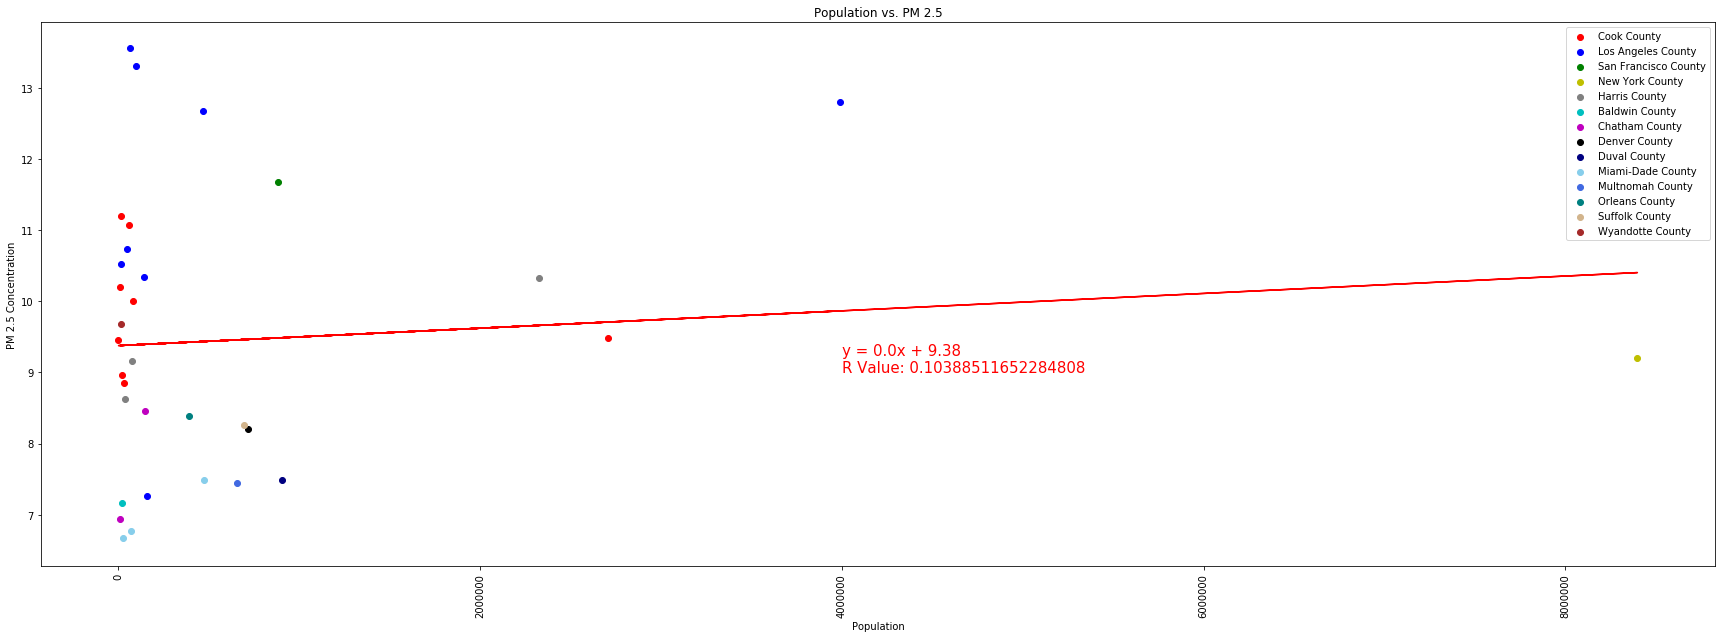

In [16]:
#plotting Scatter plots

plt.figure(figsize=(30,10))

x_values1 = clean_scatter1["Population (2018)"]
y_values1 = clean_scatter1["Average PM 2.5"]
x_values2 = clean_scatter2["Population (2018)"]
y_values2 = clean_scatter2["Average PM 2.5"]
x_values3 = clean_scatter3["Population (2018)"]
y_values3 = clean_scatter3["Average PM 2.5"]
x_values4 = clean_scatter4["Population (2018)"]
y_values4 = clean_scatter4["Average PM 2.5"]
x_values5 = clean_scatter5["Population (2018)"]
y_values5 = clean_scatter5["Average PM 2.5"]
x_values6 = clean_scatter6["Population (2018)"]
y_values6 = clean_scatter6["Average PM 2.5"]
x_values7 = clean_scatter7["Population (2018)"]
y_values7 = clean_scatter7["Average PM 2.5"]
x_values8 = clean_scatter8["Population (2018)"]
y_values8 = clean_scatter8["Average PM 2.5"]
x_values9 = clean_scatter9["Population (2018)"]
y_values9 = clean_scatter9["Average PM 2.5"]
x_values10 = clean_scatter10["Population (2018)"]
y_values10 = clean_scatter10["Average PM 2.5"]
x_values11 = clean_scatter11["Population (2018)"]
y_values11 = clean_scatter11["Average PM 2.5"]
x_values12 = clean_scatter12["Population (2018)"]
y_values12 = clean_scatter12["Average PM 2.5"]
x_values13 = clean_scatter13["Population (2018)"]
y_values13 = clean_scatter13["Average PM 2.5"]
x_values14 = clean_scatter14["Population (2018)"]
y_values14 = clean_scatter14["Average PM 2.5"]


plt.scatter(x_values1, y_values1,c="r",label="Cook County")
plt.scatter(x_values2, y_values2,c="b",label="Los Angeles County")
plt.scatter(x_values3, y_values3,c="g",label="San Francisco County")
plt.scatter(x_values4, y_values4,c="y",label="New York County")
plt.scatter(x_values5, y_values5,c="grey",label="Harris County")
plt.scatter(x_values6, y_values6,c="c",label="Baldwin County")
plt.scatter(x_values7, y_values7,c="m",label="Chatham County")
plt.scatter(x_values8, y_values8,c="k",label="Denver County")
plt.scatter(x_values9, y_values9,c="navy",label="Duval County")
plt.scatter(x_values10, y_values10,c="skyblue",label="Miami-Dade County")
plt.scatter(x_values11, y_values11,c="royalblue",label="Multnomah County")
plt.scatter(x_values12, y_values12,c="teal",label="Orleans County")
plt.scatter(x_values13, y_values13,c="tan",label="Suffolk County")
plt.scatter(x_values14, y_values14,c="brown",label="Wyandotte County")

plt.title(f"Population vs. PM 2.5")
plt.xlabel("Population")
plt.ylabel("PM 2.5 Concentration")
plt.legend()

plt.xticks(rotation=90)

#Adding regression line
linear_regression(total_df["Population (2018)"], total_df['Average PM 2.5'],(4000000,9))


plt.savefig("plot/total_city.png")

plt.show()

In [17]:
#Function to add regression line to the plot

def regression(x_values, y_values, eq_loc,ax):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,2)) + "\n" +"R values: " + str(rvalue)
    ax.plot(x_values,regress_values,"r-")
    ax.annotate(line_eq,eq_loc,fontsize=15,color="red")


<Figure size 720x360 with 0 Axes>

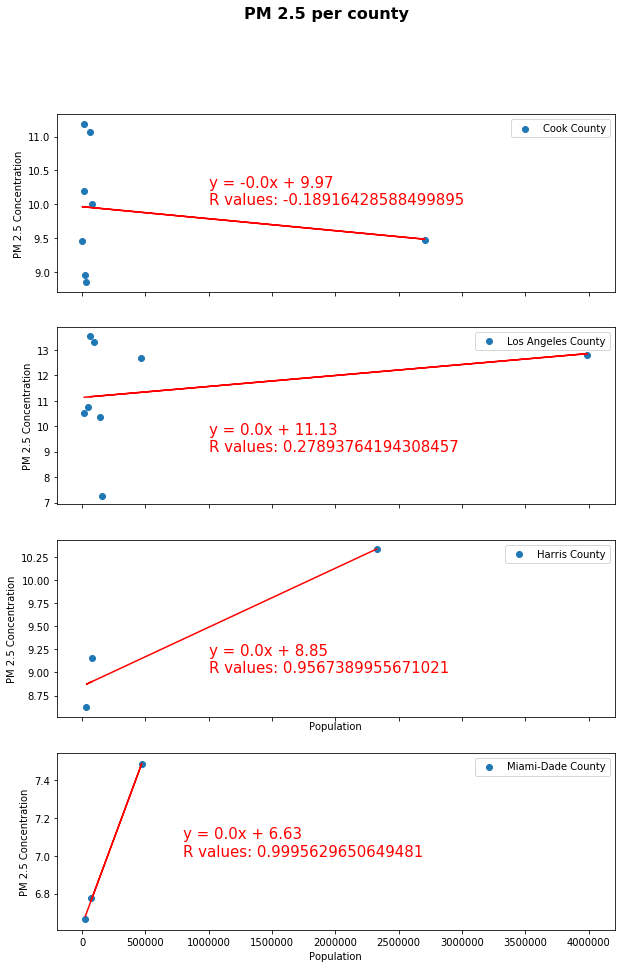

In [18]:
# Generate a facet plot of all 3 figures
plt.figure(figsize=(10,5))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(10,15))
fig.suptitle("PM 2.5 per county", fontsize=16, fontweight="bold")

ax1.scatter(x_values1, y_values1, label="Cook County")
ax1.set_ylabel("PM 2.5 Concentration")
ax1.legend()
regression(x_values1, y_values1, (1000000,10),ax1)


ax2.scatter(x_values2, y_values2,label="Los Angeles County")
ax2.set_ylabel("PM 2.5 Concentration")
ax2.legend()
regression(x_values2, y_values2, (1000000,9),ax2)


ax3.scatter(x_values5, y_values5, label="Harris County")
ax3.set_ylabel("PM 2.5 Concentration")
ax3.set_xlabel("Population")
ax3.legend()
regression(x_values5, y_values5, (1000000,9),ax3)

ax4.scatter(x_values10, y_values10, label="Miami-Dade County")
ax4.set_ylabel("PM 2.5 Concentration")
ax4.set_xlabel("Population")
ax4.legend()
regression(x_values10, y_values10, (800000,7),ax4)

plt.savefig("plot/county.png")

plt.show()

In [19]:
#Cleaning dataframe to plot state information
new_name=city_merge.rename(columns={"State_x":"State",
                                   "Average PM 2.5": "PM 2.5",
                                   "Population (2018)": "Population"})

state_df=new_name[["State","PM 2.5"]]

state_df.head()

,State,PM 2.5
0,Illinois,8.966102
1,Illinois,9.479592
2,Illinois,9.782243
3,Illinois,9.629310
4,Illinois,9.015254


In [22]:
#Setting variables for bar plot
state_plot=state_df.groupby(by="State").mean()


org_state=state_plot.reindex(["California","Oregon", "Colorado", "Texas", "Illinois", "Kansas", "Louisiana", "Alabama", "Georgia", "Florida","New York", "Massachusetts"])

org_state


,PM 2.5
State,
California,11.653701
Oregon,7.450833
Colorado,8.206528
Texas,9.851474
Illinois,9.785985
Kansas,9.685570
Louisiana,8.381356
Alabama,7.158879
Georgia,7.694409


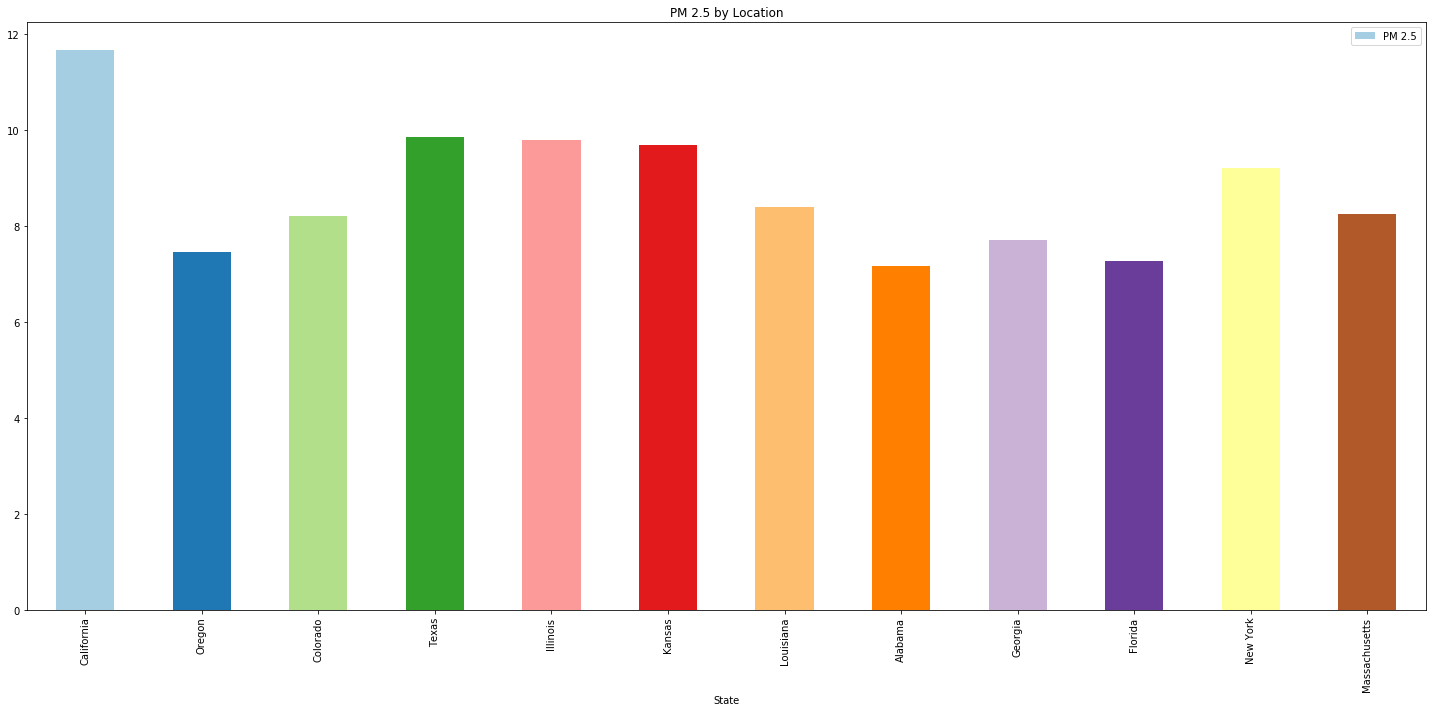

In [24]:
#Plotting bar chart
org_state.plot(kind="bar", figsize=(20,10),color=[plt.cm.Paired(np.arange(len(org_state)))])
plt.title("PM 2.5 by Location")
plt.tight_layout()

plt.savefig("plot/state.png")

plt.show()